In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Angiogram Blockage Detection
<p align="center" width="100%">
    <img width="75%" src="readme-assets/cover-photo.jpg"> 
</p>

### Step 1: Load image into memory

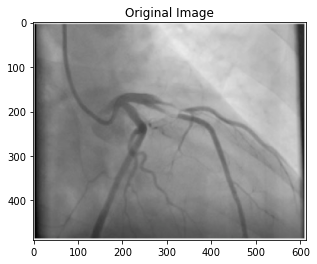

In [2]:
#Step 1 load image
image_path = 'sample-images/disease.png' #change this path to see results for another image
original_img = cv2.imread(image_path)
plt.title('Original Image')
plt.imshow(original_img)
plt.savefig('readme-assets/steps/step1.jpg', bbox_inches='tight', transparent = True)
# plt.show()

### Step 2: Crop image borders by 10%
- this is done to remove black/white borders often found in X-ray images

Old Dimensions (613,489)
New Dimensions (491,393)


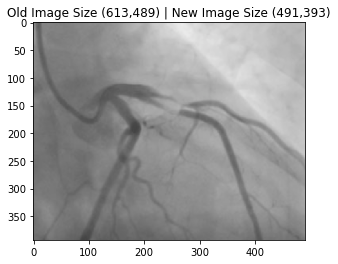

In [3]:
#Step 2 Crop image borders by 10%
print(f'Old Dimensions ({original_img.shape[1]},{original_img.shape[0]})')
x_new = int(original_img.shape[1] * .1)
y_new = int(original_img.shape[0] * .1)
img_cropped = original_img[y_new:original_img.shape[0] - y_new, x_new: original_img.shape[1] - x_new]
print(f'New Dimensions ({img_cropped.shape[1]},{img_cropped.shape[0]})')
plt.title(f'Old Image Size ({original_img.shape[1]},{original_img.shape[0]}) | New Image Size ({img_cropped.shape[1]},{img_cropped.shape[0]})')
plt.imshow(img_cropped)
plt.savefig('readme-assets/steps/step2.jpg', bbox_inches='tight', transparent = True)
plt.show()

### Step 3: Convert image to gray

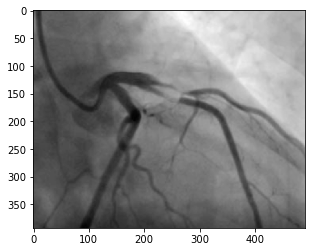

In [4]:
#Step 3 convert image to gray
gray = cv2.cvtColor(img_cropped, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap = 'gray')
plt.savefig('readme-assets/steps/step3.jpg', bbox_inches='tight', transparent = True)
plt.show()

### Step 4: Apply brightness correction to gray scaled image
- Using the formula below (`cv2.convertScaleAbs()`), one has the abiluty to normalize the distributions of pixel amplitudes across an image given `alpha` and `beta` parameters. 

<p align="center" width="50%">
    <img width="15%" src="readme-assets/convertScaleAbs.png"> 
</p>

- `cv2.convertScaleAbs` works by performing three operations sequentially. (1) Scaling, (2) Taking an absolute value, (3) Converting to unsigned 8-bit integer.  Each new pixel is the result of performing `abs(alpha + Pixel(x,y) + beta`


- The function `automatic_brightness_and_contrast(image, clip_hist_percent)` allows for dynamic calculations of `alpha` and `beta` to perform this normalization differently on each image

- The function works by:

1) Calculating the cumulative distribution of an image histogram to determine where color frequency is less than some pre-defined threshold `clip_hist_percent`. 

2) Cut the right and left side of this histogram to give us our minimum and maximum ranges

3) Calculate `alpha = 255 / (maximum_pixel - minimum_pixel)`

4) Calculate beta.  Given that `g(i, j) = 0` and `f(i, j) = minimum_pixel`

```g(i,j) = alpha * f(i,j) + beta #0 = alpha * min_pixel + beta
beta = -minimum_pixel * alpha```

### Step 4: Apply brightness correction to gray scaled image
Algorithm works by: 
1) Calculating the cumulative distribution from the histogram of a gray scaled image

2) Find the pixel value with the max frequency, and clip it with `clip_hist_percent = 1`

3) Split the clipped histogram into two parts (1) left = values below `clip_hist_percent` and (2) right = values above `clip_hist_percent`

4) Calculate alpha and beta values

`alpha = 255 / (maximum_gray - minimum_gray)`

`beta = -minimum_gray * alpha`

5) Retrieve final scaled values using 

`auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)`

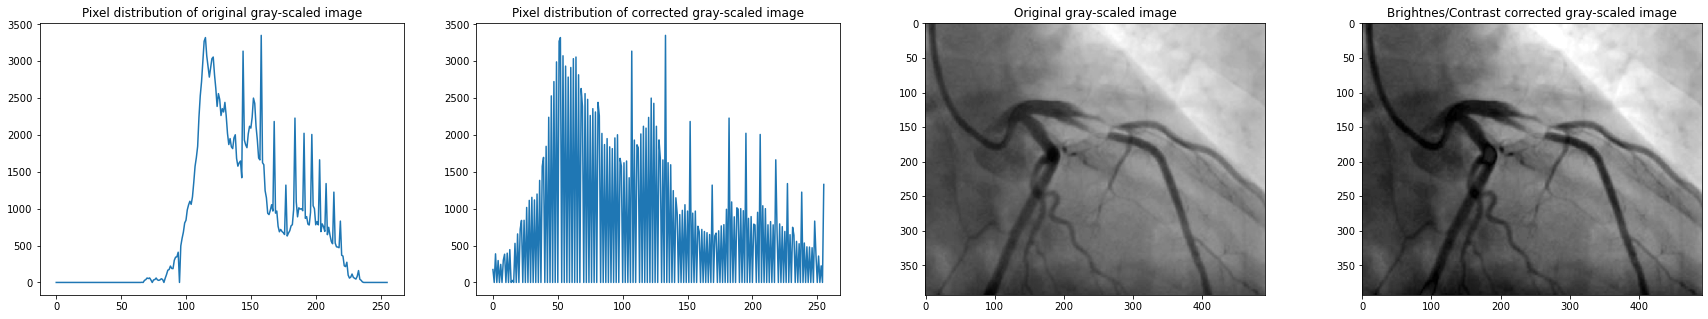

In [5]:
#Step 4 - Apply brightness correction to gray scaled image

def automatic_brightness_and_contrast(image: np.array, clip_hist_percent: int = 1) -> np.array:
    """
    This function will perform a dynamic calculation for normalizing the brightness in the image.

    Using histograms, it will balance the brightness across the image so that there is no one area that
    is a lot brighter/darker than the rest of the image
    :param image: image array (np.array)
    :param clip_hist_percent: the percentage in which the histogram will clip the pixel values
    :return: The output image (np.array).  This image will have the new brightness adjustments
    """
    # Calculate grayscale histogram
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist_size = len(hist)

    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index - 1] + float(hist[index]))

    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum / 100.0)
    clip_hist_percent /= 2.0

    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1

    # Locate right cut
    maximum_gray = hist_size - 1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1

    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha

    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return auto_result

original_hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
gray_corrected = automatic_brightness_and_contrast(gray)
new_hist = cv2.calcHist([gray_corrected], [0], None, [256], [0, 256])
fig, ax = plt.subplots(1, 4, figsize = (30,5))
ax[0].plot(original_hist)
ax[0].set_title('Pixel distribution of original gray-scaled image')
ax[1].plot(new_hist)
ax[1].set_title('Pixel distribution of corrected gray-scaled image')
ax[2].imshow(gray, cmap = 'gray')
ax[2].set_title('Original gray-scaled image')
ax[3].imshow(gray_corrected, cmap = 'gray')
ax[3].set_title('Brightnes/Contrast corrected gray-scaled image')
plt.savefig('readme-assets/steps/step4.jpg', bbox_inches='tight', transparent = True)
plt.show()

### Step 5: Apply Median Blur
- **median blur** is a commonly used method for reducing salt and pepper noise.  
- To apply a median blur, you first determine a _**kernel size**_.  In this project, I used a kernel size of 5.  The kernel size is used to determine the number of neighbors that will be incorporated in the blur method. 

```cv2.medianBlur(image, ksize = 5)```

- For example, with a neighborhood size of 5x5, 25 pixels will be used to calculate the median of all pixels. 
- After gathering the median value, the center pixel in that 5x5 area will become that median value.  
- The reason this method is so useful for salt and pepper noise is because the center pixel will _always_ be replaced with a pixel that is in the original image- as using the median calculation is more robust to outliers than compared to using an average or gaussian blur method.   

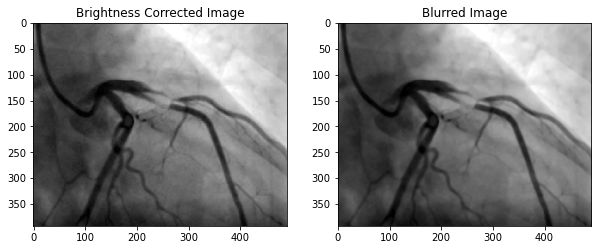

In [6]:
#Step 5 Blur the image to reduce noise
fig, ax = plt.subplots(1,2, figsize = (10,5))
blurred = cv2.medianBlur(gray_corrected, 5)
ax[0].imshow(gray_corrected, cmap = 'gray')
ax[0].set_title('Brightness Corrected Image')
ax[1].imshow(blurred, cmap = 'gray')
ax[1].set_title('Blurred Image')
plt.savefig('readme-assets/steps/step5.jpg', bbox_inches='tight', transparent = True)
plt.show()

### Step 6: Create blockSize for Adaptive Thresholding
- This process involves separating the image into equal partitions so that there are a specific number of blocks along the y-axis. In this project, I ensured that there are 12 blocks along the height of the image. 
- Because each block is created around a central pixel, the blockSize of an image must be an odd number and each block must have square dimensions.
- For example, if we want 12 blocks along the y-axis in an image with a dimension of 491x393 (WxH) pixels, it will require each block to have a height and width of 33 pixels. Given the height/width of each block, we can divide the width of the image by 33 to determine how many boxes will fit along the x-axis. 

```
height_boxes = 12
block_size = int(image_height / height_boxes) #int(393 / 12) = 32 (rounded down)
if block_size % 2 == 0: #this means it is even
    block_size += 1 #block size = 33

width_boxes = int(image_width / block_size) #int(491 / 33) = 14 (rounded down)
if width_boxes % 2 == 0: #this means it is even 
    width_boxes += 1

```

- The calculation used in [program.py](program.py) is dynamic, so these numbers are specific to the size of the image being processed
- This blockSize is utilized when applying adaptive threshold, where an algorithm will determine the best threshold based on values calculated within each of these blocks.  (Explanation for how this algorithm works is explained in the next step). 

Image Dimensions
Height 393 Width 491
# Rows: 12 | # Columns: 15
Total Blocks: 180
Total Pixel Area of each block 1089 | (33x33)


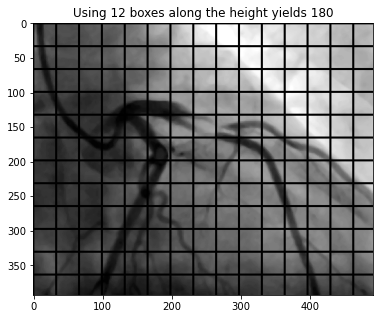

In [12]:
#Step 6 Create blocksize
blurred_copy = blurred.copy() #used for sample image below
print(f'Image Dimensions\nHeight {blurred_copy.shape[0]} Width {blurred_copy.shape[1]}')
height_boxes = 12
block_size = int(blurred.shape[0] / height_boxes) 
block_size = block_size + 1 if block_size % 2 == 0 else block_size #ensure that block size is odd number

neighbors = block_size * block_size #calculates the number of pixels within each block (block_sizexblock_size)

width_boxes = int(blurred.shape[1] / block_size) #calculates how many columns will be created based on the above calculations
width_boxes = width_boxes + 1 if width_boxes % 2 == 0 else width_boxes #entures that the number is odd

total_blocks = (height_boxes * width_boxes)

print(f'# Rows: {height_boxes} | # Columns: {width_boxes}')
print(f'Total Blocks: {total_blocks}')
print(f'Total Pixel Area of each block {neighbors} | ({block_size}x{block_size})')
for y in range(0, blurred.shape[0], block_size):
    for x in range(0, blurred.shape[1], block_size):
        cv2.rectangle(blurred_copy, (x, y), (x+block_size, y+block_size), (0,0,255), 2)
    
plt.figure(figsize=(20,5))
plt.title(f'Using {height_boxes} boxes along the height yields {total_blocks}')
plt.imshow(blurred_copy, cmap = 'gray')
plt.savefig('readme-assets/steps/step6.jpg', bbox_inches='tight', transparent = True)
plt.show()

### Step 7:  Apply Adaptive thresholding 
- Here, I applied mean adaptive thresholding using a blockSize of 33 and a constant of 10
- When applying adaptive thresholding, you have the option of using _**Arithmetic**_ or _**Gaussian**_ mean for calculating the threshold within each image.  In this project, I used Arithmetic mean (`cv2.ADAPTIVE_THRESH_MEAN_C`) as I believe Gaussian mean is not a good method for this application.  In Gaussian mean (`cv2.ADAPTIVE_THRESH_GAUSSIAN_C`), the _**weighted**_ average is performed so that the central pixel of the block contributes more weight to the average. In the [example image](readme-assets/steps/step7.jpg) below, we can see that Gaussian mean reduces noise present in the image, however, it does not preserve the integrity of the vessels as well as arithmetic mean.  

`cv.ADAPTIVE_THRESH_MEAN_C`: The threshold value is the mean of the neighbourhood area minus the constant C.

`cv.ADAPTIVE_THRESH_GAUSSIAN_C`: The threshold value is a gaussian-weighted sum of the neighbourhood values minus the constant C.

<p align="center" width="50%">
    <img width="15%" src="readme-assets/Gaussian_Mean.png"> 
</p>

- The threshold for each block is calculated by taking the arithmetic mean of the blockSizexBlockSize and subtracting it by `C = 10`.  In the example in the previous step, using 12 block rows yields a blockSize of 33.  Given this, we will take the arithmetic average pixel amplitude within each 33x33 block and subtract that average by 10 to determine the threshold for that specific block. As mentioned in Step 6, the blockSize will change based on the original image dimension so the math explained here applies _only_ to that image - however, the logic is the same. In Step 6, I obtained 12 block rows (y) and 15 block columns (x).  Therefore, there will be a total of 180 (12 * 15) thresholds that correspond to each partitioned area.  

<p align="center" width="50%">
    <img width="15%" src="readme-assets/Adaptive_Threshold.png"> 
</p>

- After determining the thresholds for each specific block, an algorithm is applied where each pixel in a particular block is converted to either 0 (black) or 255 (white) based on that block's calculated threshold. There are _**2 procedures**_ that are popular:

1) `cv2.THRESH_BINARY`: Each pixel greater than or equal to the threshold value will be converted to a defined max value (255) while every pixel below the threshold will be converted to 0 (black)

<p align="center" width="100%">
    <img width="25%" src="readme-assets/THRESH_BINARY.png"> 
</p>

2) `cv2.THRESH_BINARY_INV`: Each pixel greater than or equal to the threshold value will be converted to 0 (black) while every pixel below the threshold will be converted to a defined max value (255)

<p align="center" width="100%">
    <img width="25%" src="readme-assets/THRESH_BINARY_INV.png"> 
</p>

- In this project, I used `cv2.THRESH_BINARY_INV` which converted every pixel above the threshold to black while converting pixels below the threshold to white (max value of 255).  By doing this, we can interpret the black regions in the image as possible blood cells and thus our regions of interest.

```
threshold_img = cv2.adaptiveThreshold(original_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, block_size, 10)
```


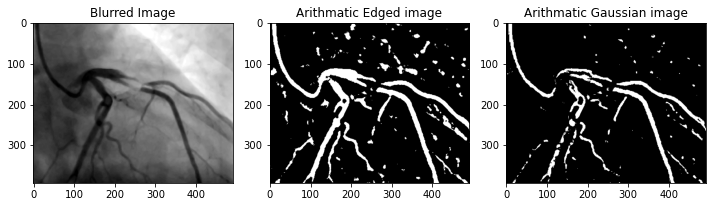

In [8]:
#Step 7 Apply adaptive thresholding using the block size above
constant = 10
edged_gaussian = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, block_size, constant)
edged_arithmatic = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, block_size, constant)
fig, ax = plt.subplots(1, 3, figsize = (10, 5))
ax[0].imshow(blurred, cmap = 'gray')
ax[0].set_title('Blurred Image')
ax[1].imshow(edged_arithmatic, cmap = 'gray')
ax[1].set_title('Arithmatic Edged image')
ax[2].imshow(edged_gaussian, cmap = 'gray')
ax[2].set_title('Arithmatic Gaussian image')
plt.tight_layout()
plt.savefig('readme-assets/steps/step7.jpg', bbox_inches='tight', transparent = True)
plt.show()

#used for below calculations
edged_adap = edged_arithmatic.copy()

### Step 8: Get Contours
- I performed a contour operation to find the edges within the image.  These edges are the white areas shown in Step 7
- In order to perform a contour operation, I first created a _**Structuring Element**_: which is a type of kernel that performs a particular operation on the image.  
- When creating a structuring element, popular morphological operations are

1) `cv2.MORPH_RECT`: rectangular structuring element

$\begin{bmatrix}
  1.00 &  1.00 &  1.00 &  1.00\\
  1.00 &  1.00 &  1.00 &  1.00\\
  1.00 &  1.00 &  1.00 &  1.00\\
  1.00 &  1.00 &  1.00 &  1.00
\end{bmatrix}$


2) `cv2.MORPH_CROSS`: Cross-shaped structuring element

$\begin{bmatrix}
  0.00 &  0.00 &  1.00 &  0.00\\
  0.00 &  0.00 &  1.00 &  0.00\\
  1.00 &  1.00 &  1.00 &  1.00\\
  0.00 &  0.00 &  1.00 &  0.00
\end{bmatrix}$

3) `cv2.MORPH_ELLIPSE`: Circular structuring element. 

$\begin{bmatrix}
  0.00 &  0.00 &  1.00 &  0.00\\
  1.00 &  1.00 &  1.00 &  1.00\\
  1.00 &  1.00 &  1.00 &  1.00\\
  1.00 &  1.00 &  1.00 &  1.00
\end{bmatrix}$

- In this project, I used circular structuring element (`cv2.MORPH_CROSS`) and a kernel size of (3x3). In the [image](readme-assets/steps/step8.jpg) below, the circular structuring element was better at maintaining the blood vessel. 

- Using `cv2.morphologyEx`, I apply a convoltuion between each 3x3 block in the image with the ELLIPSE_MATRICS above matrix.  

- After convolving the image, we apply `cv2.findContours` with `cv2.RETR_EXTERNAL` which is an algorithm that detects changes in colors and perceives them as boundaries.  In this case, every point where a black pixel is right next to a white pixel is processed as a boundary.  This function will return an array of values, where the length of the array corresponds to each contours region.  I parsed the array to only include contours with a minimum area of 70 pixels

- In the image below, the contour regions are those drawn in black. Although the image looks similar to the ones in previous steps, the difference here is that I obtained (x,y) coordinates for each point around the blood vessels.  

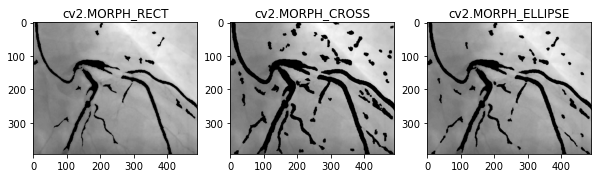

In [71]:
#Step 8, get contours
image_dict = {}
struct_element = {'cv2.MORPH_RECT': cv2.MORPH_RECT, 'cv2.MORPH_CROSS': cv2.MORPH_CROSS, 'cv2.MORPH_ELLIPSE': cv2.MORPH_ELLIPSE}
fig, ax = plt.subplots(1, 3, figsize = (10,5))
img_idx = 0
output_dict = {}
for k, e in struct_element.items():
    min_contour_area = 50 #minimum area allowed for each contour - this is meant to reduce noise
    thresh = cv2.morphologyEx(edged_adap, e, np.ones((3,3), np.uint8))
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    contours = [i for i in contours if cv2.contourArea(i) >= min_contour_area]
    edged_contour = img_cropped.copy()
    for idx, c1 in enumerate(contours): 
        cv2.drawContours(edged_contour, [c1], -1, (0,0,0), -1)
    edged_contour = cv2.cvtColor(edged_contour, cv2.COLOR_BGR2GRAY)
    ax[img_idx].imshow(edged_contour, cmap = 'gray')
    ax[img_idx].set_title(f'{k}')
    img_idx += 1
    output_dict[k] = edged_contour
    
fig.savefig('readme-assets/steps/step8.jpg', bbox_inches='tight', transparent = True)
plt.show()

edged_contour = output_dict['cv2.MORPH_ELLIPSE'].copy()

### Step 9: Perform another round of thresholds and then dilate the image
- Given the images created in Step 8, I applied another threshold operation to create a binary image where every pixel is either 0 (black) or 255 (white)
- Because I drew and filled each contour in black, I know that the blood vessels have a pixel value of 0
- I apply a simple threshold algorithm that will turn every pure black pixel to 255, while converting any other pixel greater than 0 to 255. 
- **_Dilation_** (`cv2.dilate()`) Is the process of that increases the bright regions of the image. The process of dilation is as follows

1) Create a kernel and scan the image with that kernel
2) Within each overlapping block of the kernel and the original image, we replace the center pixel with that maximum value.
3) If more than one iteration is passed, then you repeat this process for the remaining iterations.  The more iterations you pass, the brighter the image will get.  

- As shown in the image below, performing dilation with `iterations = 2` on this image decreased the minimum distance between each contour point, allowing for better blockage estimation in the final step.  


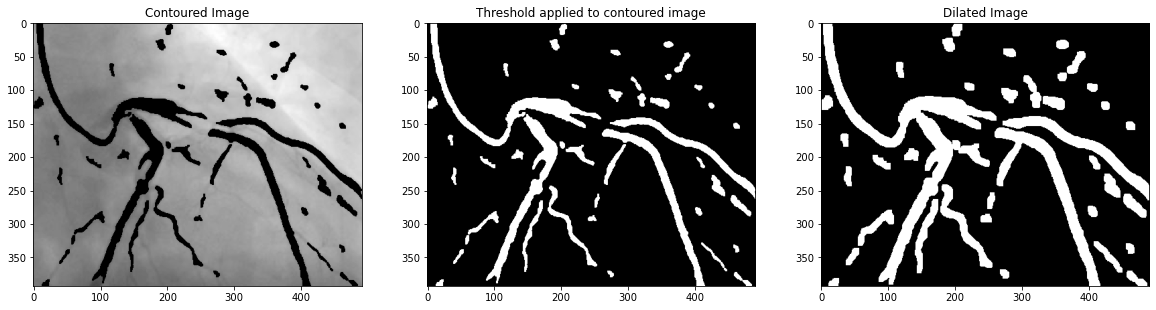

In [72]:
#Step 9 Perform another round of threshold to include only the contoured areas then dilate the image to reduce the space between contours
threshed = cv2.threshold(edged_contour, 0, 255, cv2.THRESH_BINARY_INV)[1]
dilated = cv2.dilate(threshed, None, iterations = 2)
fig, ax = plt.subplots(1,3, figsize=(20,5))
ax[0].imshow(edged_contour, cmap = 'gray')
ax[0].set_title('Contoured Image')
ax[1].imshow(threshed, cmap = 'gray')
ax[1].set_title('Threshold applied to contoured image')
ax[2].imshow(dilated, cmap = 'gray')
ax[2].set_title('Dilated Image')
plt.savefig('readme-assets/steps/step9.jpg', bbox_inches='tight', transparent = True)
plt.show()

### Step 10:



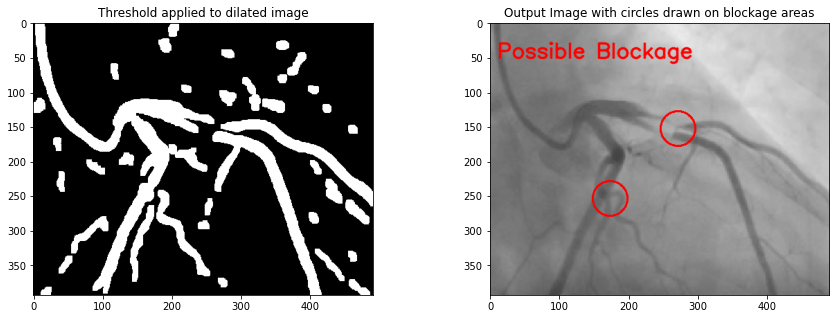

In [73]:
#Step 10 Another contour operation to get outlines of the dilated image.  
def find_if_close(cnt1: list, cnt2: list, min_dist: int=10):
    """
    This function will perform a euclidean distance between two contours to find the distance of the closest points
    If the distance is below the min_dist parameter, it will return the idx of that contour where that occurs, otherwise it
    will return False
    :param cnt1: List containing points for the first contour
    :param cnt2: List containing points for the second contour
    :param min_dist: The minimum distance in which a contour can be to the other contour. Default is 10 pixels
    :return: The index if it is within that distance, otherwise False (no points are within the distance)
    """
    row1, row2 = cnt1.shape[0], cnt2.shape[0]
    for i in range(row1):
        for j in range(row2):
            dist = np.linalg.norm(cnt1[i] - cnt2[j])
            #             print(dist)
            if abs(dist) < min_dist:
                return i
            elif i == row1 - 1 and j == row2 - 1:
                return False

min_contour_area = 1250
output_image = img_cropped.copy()
thresh = cv2.morphologyEx(dilated, cv2.MORPH_ELLIPSE, np.ones((3,3), np.uint8))
contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
contours = [i for i in contours if cv2.contourArea(i) > min_contour_area]
detections = 0
for idx1, c1 in enumerate(contours):
    for idx2, c2 in enumerate(contours):
        if idx2 == idx1:
            continue
        point = find_if_close(c1, c2, min_dist = 10)
        if point: 
            detections += 1
            center = tuple(contours[idx1][point].squeeze())
            cv2.circle(output_image, center, 25, (0,0,255), 2)

message = f'Possible Blockage' if detections > 0 else 'No Blockage Detected'
color = (0, 0, 255) if detections > 0 else (0, 255, 0)
output_image = cv2.putText(output_image, message, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)

fig, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].imshow(thresh, cmap = 'gray')
ax[0].set_title('Threshold applied to dilated image')
ax[1].imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
ax[1].set_title('Output Image with circles drawn on blockage areas')
plt.savefig('readme-assets/steps/step10.jpg', bbox_inches='tight', transparent = True)
plt.show()